<a href="https://colab.research.google.com/github/jrezaa/SmartGridAnalytics/blob/main/Final_Project_JeffRezazada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Smart Grid Analytics: Power Balance Management System

Lets check out the data!

## Data Analysis

In [ ]:
# Installing required libraries for hyper parameter tuning
%pip install bayesian-optimization

In [ ]:
import pandas as pd
raw_data = pd.read_csv("./sample_data/smart_grid_stability_augmented.csv")
print(raw_data)

# Print all features
print("All features: ",list(raw_data.columns))

print("Data size: ", raw_data.shape[0])

has_nan = raw_data.isna().any().any()

print("Are there any NaN values in the DataFrame?", has_nan)

# Print all categorical features
print("Categorical features: ",list(raw_data.select_dtypes(include=['object']).columns))


           tau1      tau2      tau3      tau4        p1        p2        p3  \
0      2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1      9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2      8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3      0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4      3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   
...         ...       ...       ...       ...       ...       ...       ...   
59995  2.930406  2.376523  9.487627  6.187797  3.343416 -1.449106 -0.658054   
59996  3.392299  2.954947  1.274827  6.894759  4.349512 -0.952437 -1.663661   
59997  2.364034  8.776391  2.842030  1.008906  4.299976 -0.943884 -1.380719   
59998  9.631511  2.757071  3.994398  7.821347  2.514755 -0.649915 -0.966330   
59999  6.530527  4.349695  6.781790  8.673138  3.492807 -1.532193 -1.390285   

             p4        g1        g2        g3      

### Features:

Looking at the data, we have 12 features, as well as 1-2 labels. The stab and stabf essentially relay the same information, which should be caught by the correlation heat map.

<h2>tau1 - tau4 (Reaction Time of Producer and Consumers)</h2>
<ul>
    <li><b>tau1 (Reaction time - Energy producer):</b> Represents the time it takes for an energy producer to react to changes or demands in the grid. A faster reaction time could indicate a more responsive and potentially more stable grid system.</li>
    <li><b>tau2 (Reaction time - Consumer 1):</b> Represents the reaction time of Consumer 1 to changes in the grid. Faster reaction times could correlate with better grid stability and efficiency.</li>
    <li><b>tau3 (Reaction time - Consumer 2):</b> Similar to tau2, it indicates the reaction time of Consumer 2 to grid changes.</li>
    <li><b>tau4 (Reaction time - Consumer 3):</b> Similar to tau2 and tau3, it indicates the reaction time of Consumer 3</li>
</ul>

<h2>p1 - p4 (Power Balance of Producer and Consumers)</h2>
<ul>
    <li><b>p1 (Power balance - Energy producer):</b> A measure of the power output balance for the energy producer. It indicates whether the producer is meeting, exceeding, or falling short of the power demand.</li>
    <li><b>p2 (Power balance - Consumer 1):</b> Indicates the power balance for Consumer 1, showing their power usage compared to expectations or allocations.</li>
    <li><b>p3 (Power balance - Consumer 2):</b> Reflects the power balance for Consumer 2, providing insight into their energy consumption patterns.</li>
    <li><b>p4 (Power balance - Consumer 3):</b> Similar to p2 and p3, it represents the power balance for Consumer 3.</li>
</ul>

<h2>g1 - g4 (Price Elasticity Coefficient of Producer and Consumers)</h2>
<ul>
    <li><b>g1 (Price elasticity coefficient - Energy producer):</b> Measures how sensitive the energy producer is to price changes. Higher elasticity indicates a significant change in electricity production in response to price fluctuations.</li>
    <li><b>g2 (Price elasticity coefficient - Consumer 1):</b> Represents the price elasticity of Consumer 1, showing their sensitivity to price changes in terms of electricity consumption.</li>
    <li><b>g3 (Price elasticity coefficient - Consumer 2):</b> Similar to g2, it indicates the price elasticity of Consumer 2.</li>
    <li><b>g4 (Price elasticity coefficient - Consumer 3):</b> Indicates the price elasticity of Consumer 3, reflecting their economic responsiveness to electricity pricing.</li>
</ul>





##Cleaning the Data

The label column is categorical, and we should encode these in simple binary labels, 0 being stable, 1 being unstable.

In [ ]:
encoded_labels = raw_data.copy()
encoded_labels['stabf'] = encoded_labels['stabf'].map({'stable': 0, 'unstable': 1})

counts = encoded_labels['stabf'].value_counts()
print(counts)


print(f"\nPercentage of stable vs total: {counts[0]/(counts[0] + counts[1])}")

1    38280
0    21720
Name: stabf, dtype: int64

Percentage of stable vs total: 0.362


The encoding was successful, and we can see the data is roughly split into 36% stable data vs 64% stable data.

### Low Variance Removal

The next step would be to remove any features with low variance. This is done as low variance in features suggests that the feature does not contribute new information for the machine learning model, which removal, can lead to faster training times. If the features don't help the model, we should remove them.

In [ ]:
# Creating function to remove low variance in features
def remove_low_variance(data, threshold):
  var_removal_list = []
  for col in data.columns:
    if data[col].var() < threshold:
        var_removal_list.append(col)

  print(f"Removing the following from feature set: \n{var_removal_list = }")

  # Return the data with dropped columns
  return data.drop(columns=var_removal_list)

# Setting variation threshold
VARIATION_THRESHOLD = 1e-3

low_var_removed = remove_low_variance(encoded_labels, VARIATION_THRESHOLD)

Removing the following from feature set: 
var_removal_list = []


We can see that with the threshold set of 1e-3, no features have low variance. We should not remove any features due to variance.

###Feature Selection

First we have to look at the heatmap for the correlation matrix.

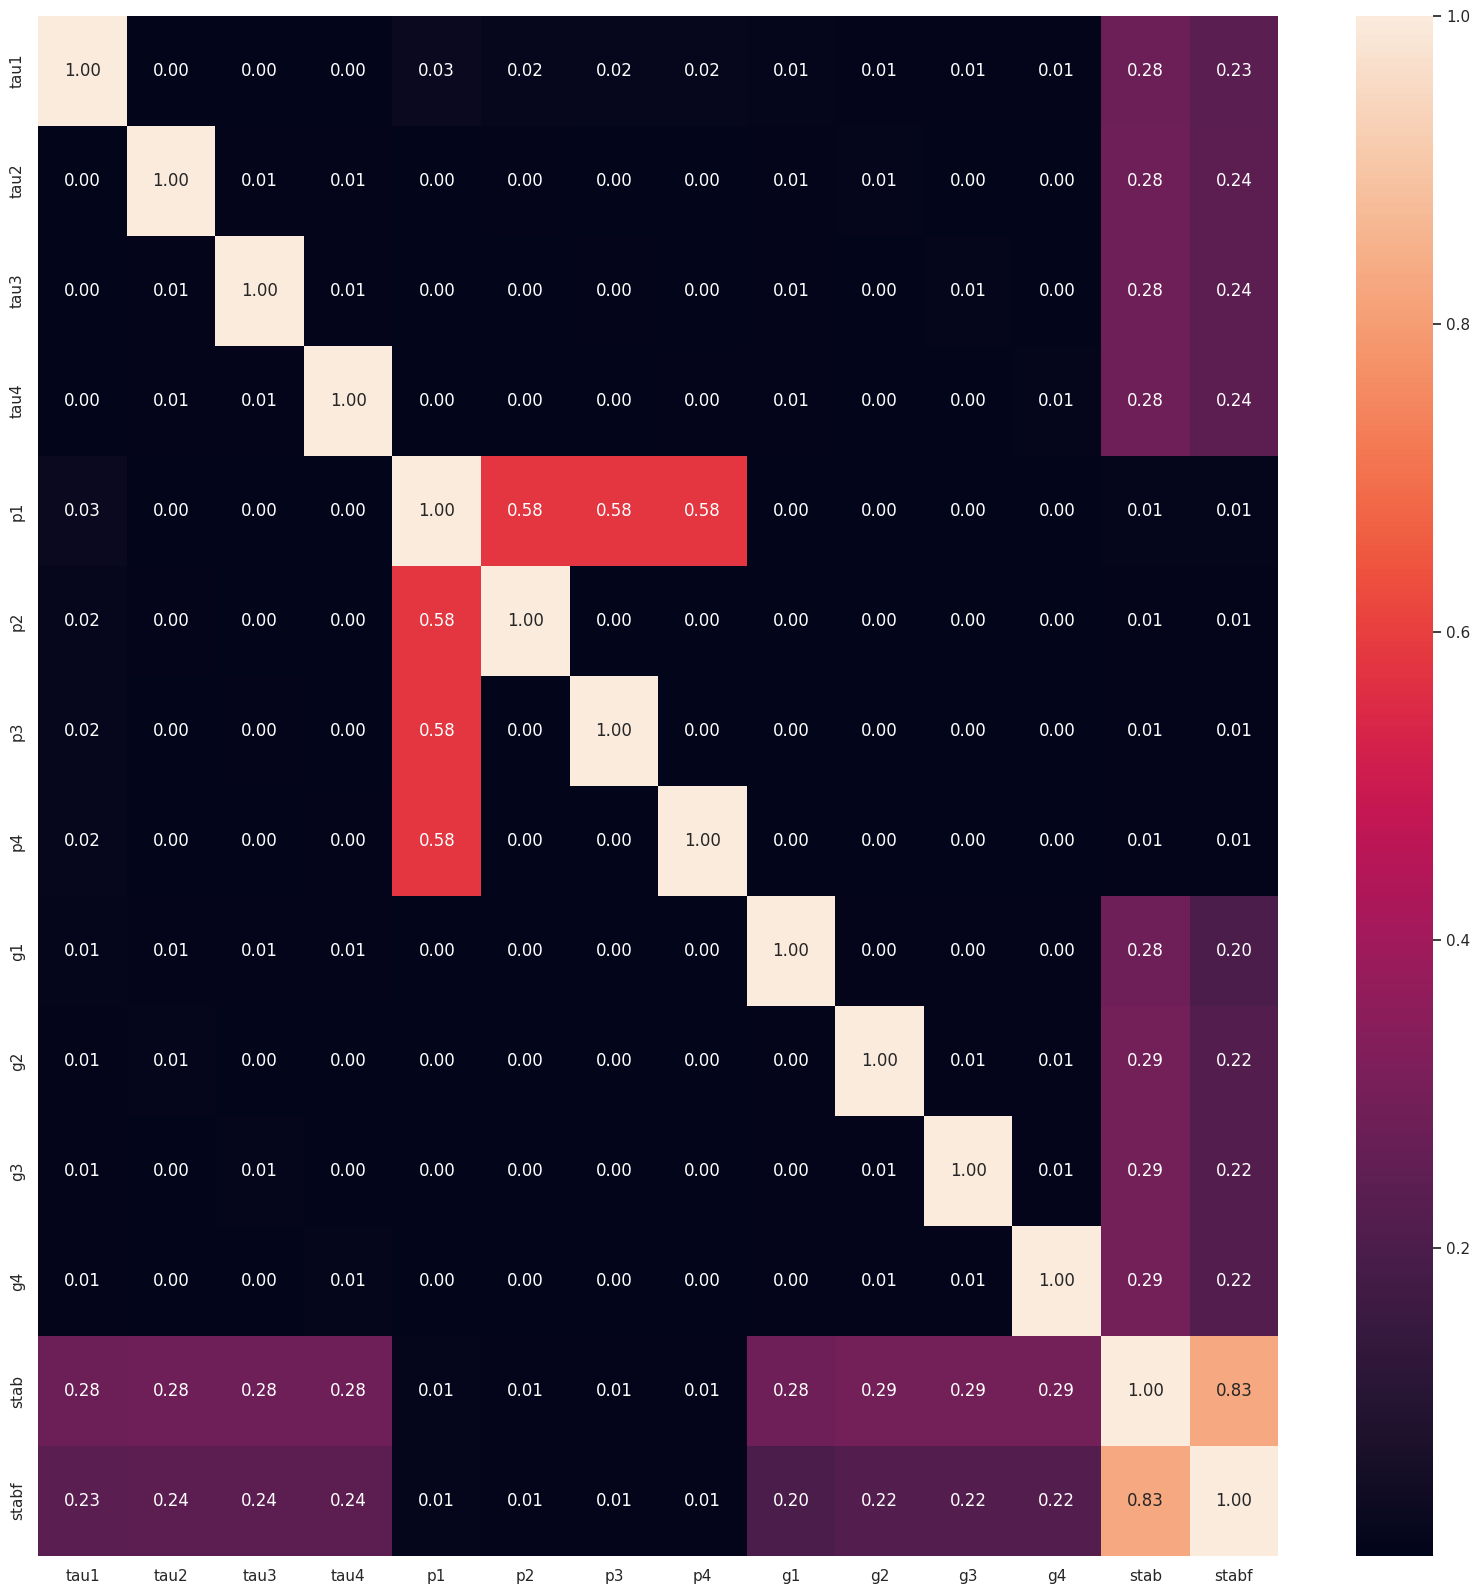

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating function for heatmaps
def heatmap(corr_matrix):
  corr_matrix.style.background_gradient(cmap="coolwarm", axis=None)
  sns.set(rc={"figure.figsize": (20, 20)})
  sns.heatmap(corr_matrix, fmt="0.2f", annot=True, xticklabels=corr_matrix.columns.values,
              yticklabels=corr_matrix.columns.values)
  plt.show()

# # Removing the dependent variable "Price"
# cars_data_no_price = cars_data.copy()
# cars_data_no_price.drop("Price", inplace=True, axis=1)

# Getting correlation matrix
corr_matrix = abs(low_var_removed.corr())

# Showing heatmap
heatmap(corr_matrix)

As we suspected, stab and stabf are correlated, we will remove stabf, as the labels are not necessary. Looking at the heatmap, as we only have 14 features, and having a generous cutoff of 0.7, we do not need to remove any features due to correlation. Earlier encoding was performed for analysis, but due to the nature of the binary data holding less information than the stab values, I chose to remove the encoded values.

We will still check using python code, to be sure that the code is robust to data changes.

In [ ]:
# Creating function to find correlated pairs
def find_correlated_pairs(dataset, corr_matrix, threshold):
    highly_correlated_features = set()
    for col in list(dataset.columns):
      for ind, val in enumerate(corr_matrix[col]):
        if abs(val) > threshold and val != 1.0:
          correlated_feature = corr_matrix.index[ind]
          highly_correlated_features.add(tuple(sorted((col, correlated_feature))))

    return highly_correlated_features

# Choosing correlation threshold
CORRELATION_THRESHOLD = 0.7

correlated_features = find_correlated_pairs(low_var_removed, corr_matrix, CORRELATION_THRESHOLD)
print(f"{correlated_features = }")

feature_selected = low_var_removed.drop("stab", axis=1)


correlated_features = {('stab', 'stabf')}


We can see that the correlated features are caught ("stab", "stabf").

### P Value Analysis

Another aspect of feature selection is based on p-values, so let's check these.

In [ ]:
from scipy.stats import pearsonr

# Find p-values from the dataset knowing the target_variable
def find_p_values(dataset, features, target_variable):
  p_values = {}
  for feature in features:
    if dataset[feature].dtype != 'object':  # Consider only numerical columns
      corr, p_value = pearsonr(dataset[feature], dataset[target_variable])
      p_values[feature] = p_value  # Store the actual p-value

  return p_values

# Removing the largest p-value from the pairs
def detect_large_p_values(data):
  p_value_removal_list = []
  all_features = list(data.columns)
  all_p_values = find_p_values(data, all_features, "stabf")

  print(f"{all_p_values = }")

  # Identifying high p-values
  for feature, p_value in all_p_values.items():
    if p_value > 0.05:
        p_value_removal_list.append((feature, p_value))

  # Printing features with high p-values
  if p_value_removal_list:
    print("Features with High P-values:")
    for feature, p_value in p_value_removal_list:
      print(f"{feature}: {p_value:.2e}")
  else:
    print("No features with p-value higher than 0.05 were found.")

detect_large_p_values(feature_selected)

p_consumer_removed = feature_selected.copy()
p_consumer_removed = p_consumer_removed.drop(['p2', 'p3', 'p4'], axis=1)

all_p_values = {'tau1': 0.0, 'tau2': 0.0, 'tau3': 0.0, 'tau4': 0.0, 'p1': 0.014923868363159074, 'p2': 0.15873157892011802, 'p3': 0.15873157892011802, 'p4': 0.15873157892011802, 'g1': 0.0, 'g2': 0.0, 'g3': 0.0, 'g4': 0.0, 'stabf': 0.0}
Features with High P-values:
p2: 1.59e-01
p3: 1.59e-01
p4: 1.59e-01


Looking at these features, the p-values are indeed above 0.05 threshold. Although in the normal case, these would be removed, I believe due to the objective of this algorithm, we should keep them.

<br>
<h4><b>The following was from a previous edit:</b></h4>
*While the higher p-values for p2, p3, and p4 suggest they are not statistically significant predictors, this doesn't automatically mean they have no practical relevance. They might capture aspects of the data that are not immediately apparent but could still be useful in certain contexts or combined with other features. We will verify this decision in later portions of the code and save both datasets (p_consumer_removed is the dataset without p2-p4).*

<br>

<h4><b>After Testing:</b></h4>
It was found that p2-p4 negatively affected the performance of the model, and should be removed. I believe this is because they do not provide very useful data to the model, yet increase the complexity. Due to this, the model having more parameters to consider, had a more difficult time converging to an acceptable performance. They were removed for the analysis.

***To verify, please use "feature_selected" dataframe instead of "p_consumer_removed" data.***

### Normalizing
After cleaning the data, the data should be normalized. Normalizing data for machine learning ensures that features have the same scale, which can improve convergence speed in gradient-based algorithms and maintain consistent feature importance across various models.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Assuming 'feature_selected' and 'p_consumer_removed' are your dataframes
# And 'stabf' is the categorical column that you don't want to normalize

# Separate numerical and categorical data
numerical_feature_selected = feature_selected.drop(columns=['stabf'])
categorical_feature_selected = feature_selected[['stabf']]

numerical_p_consumer_removed = p_consumer_removed.drop(columns=['stabf'])
categorical_p_consumer_removed = p_consumer_removed[['stabf']]


# Apply scaling to numerical data
scaled_numerical_feature_selected = pd.DataFrame(scaler.fit_transform(numerical_feature_selected), columns=numerical_feature_selected.columns)
scaled_numerical_p_consumer_removed = pd.DataFrame(scaler.fit_transform(numerical_p_consumer_removed), columns=numerical_p_consumer_removed.columns)

# Concatenate the scaled numerical data back with the categorical data
scaled_data = pd.concat([scaled_numerical_feature_selected, categorical_feature_selected], axis=1)
scaled_data_p_removed = pd.concat([scaled_numerical_p_consumer_removed, categorical_p_consumer_removed], axis=1)

### Removing Outliers

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an effective clustering algorithm that can also be used for outlier detection.

First lets visualize the optimal eps value to use for DBSCAN at min_samples = 5. The following graph shows the kth nearest neighbour distance, where k = 5.

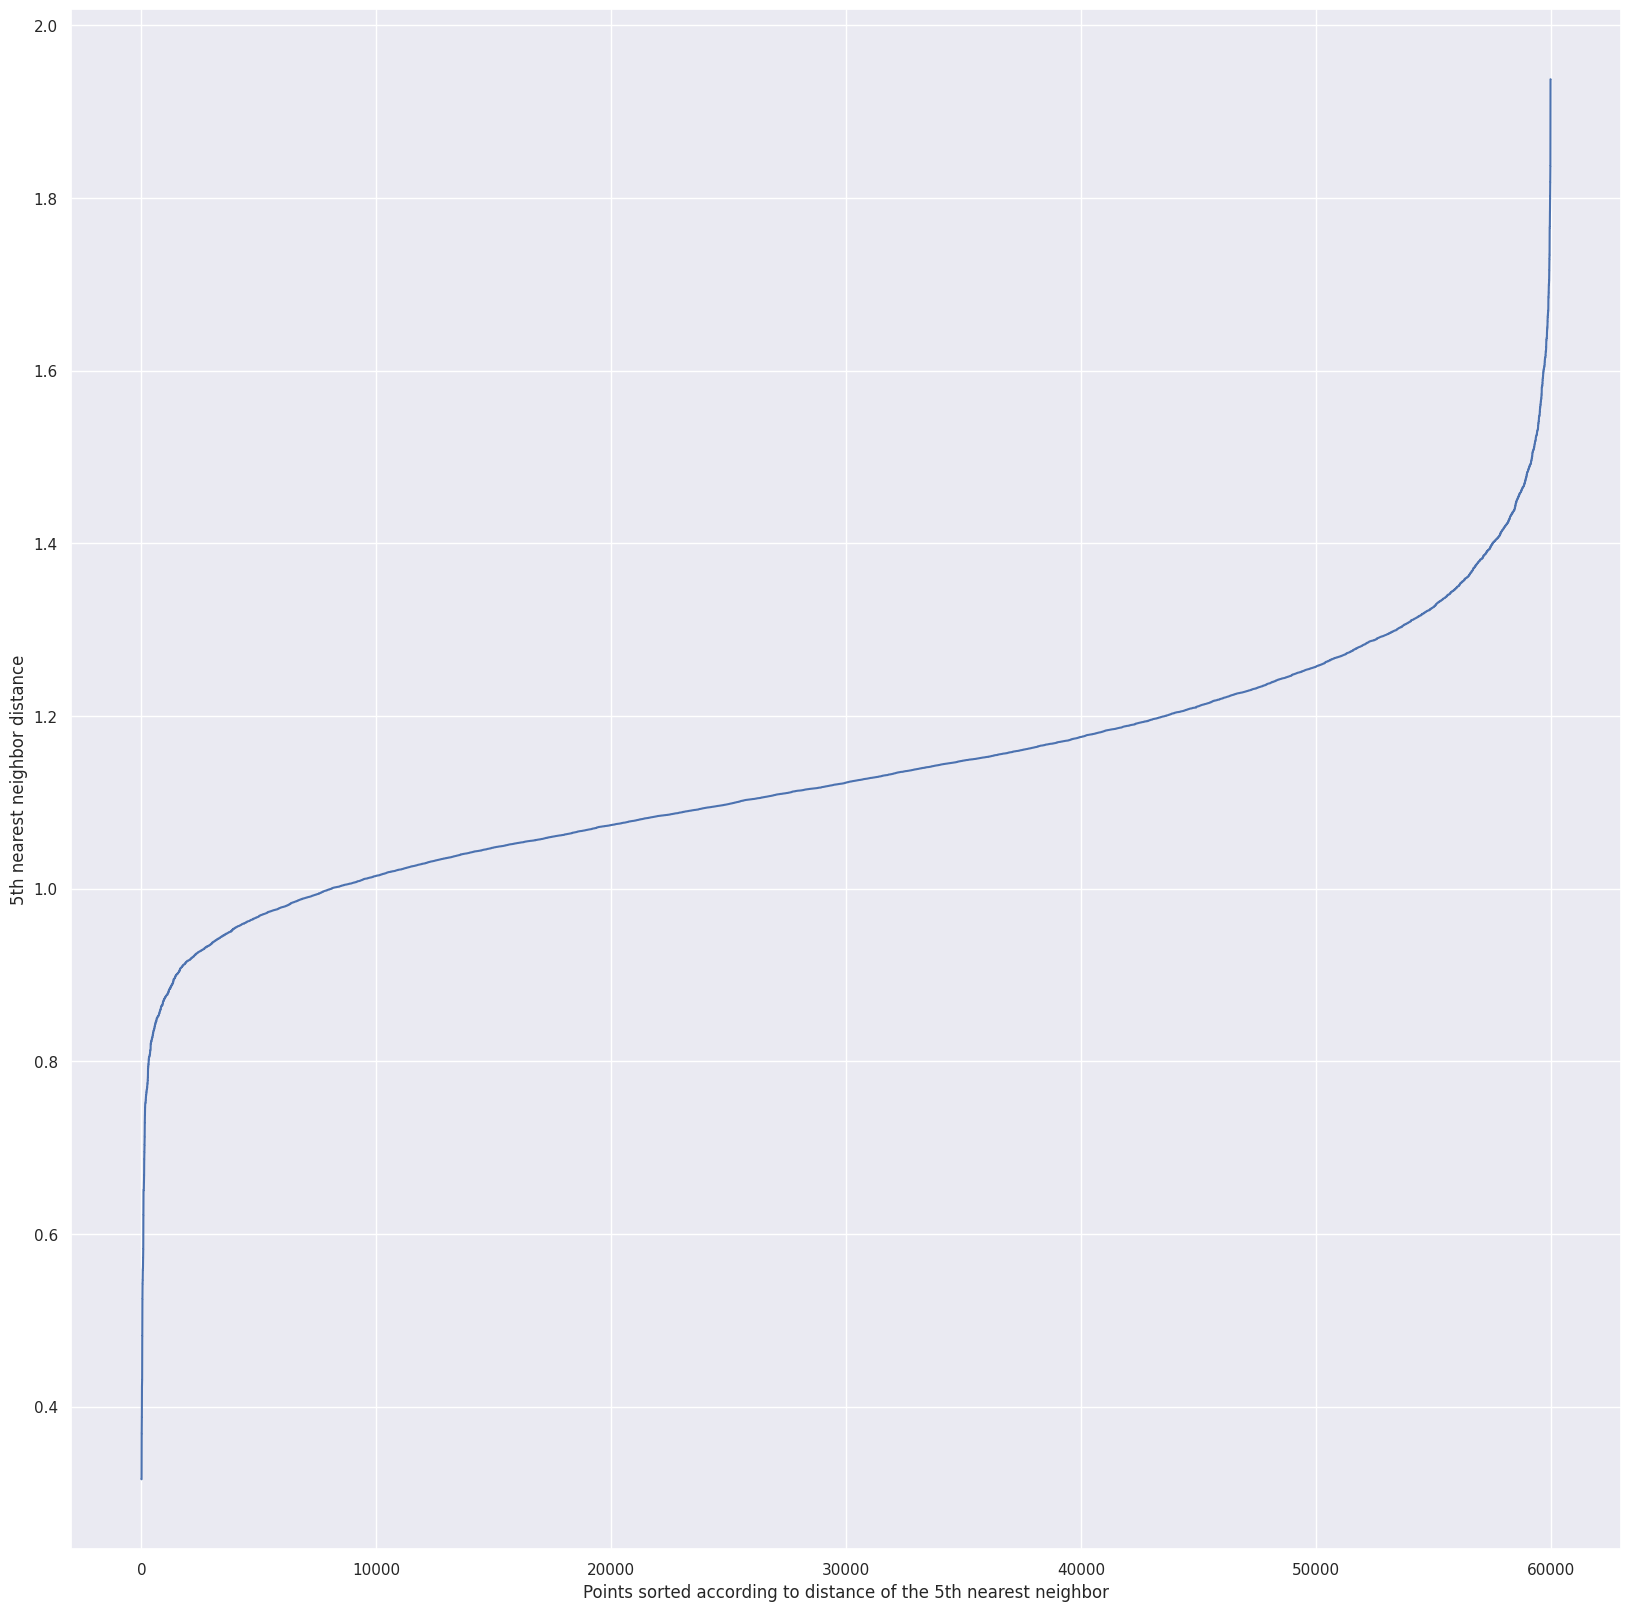

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

def plot_k_distance(df, k=5):
  """
  Plot the k-distance graph to find the optimal eps value for DBSCAN.

  Parameters:
  df (DataFrame): The input DataFrame.
  k (int): Number of neighbors to use for the k-neighbors calculation.

  """
  # Store the 'stabf' column in a separate variable
  stabf_labels = df['stabf']

  # Remove the 'stabf' column from the DataFrame
  df = df.drop(columns=['stabf'])
  # Calculate the distance to the kth nearest neighbor for each point
  nbrs = NearestNeighbors(n_neighbors=k).fit(df)
  distances, indices = nbrs.kneighbors(df)

  # Sort and plot distances
  sorted_distances = np.sort(distances[:, k-1])
  plt.plot(sorted_distances)
  plt.xlabel("Points sorted according to distance of the " + str(k) + "th nearest neighbor")
  plt.ylabel(str(k) + "th nearest neighbor distance")
  plt.show()

plot_k_distance(scaled_data_p_removed)

Looking at this graph showing the distances, we want to find an "elbow point" to set eps for DBSCAN. It looks like an appropriate value can be set around 1.3.

Although outliers may or may not affect our algorithm, it should be noted that outliers may be necessary in analysis, as some outliers may carry important information. For this reason, the model will be trained on both to validate whether or not outliers should be removed.

In [ ]:
from sklearn.cluster import DBSCAN

def remove_outliers(df, eps=1.3, min_samples=5):
  """
  Remove outliers from a DataFrame using DBSCAN.

  Parameters:
  df (DataFrame): The input DataFrame.
  eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
  min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

  Returns:
  DataFrame: The cleaned DataFrame with outliers removed.
  int: The number of outliers removed.
  """
  # Store the 'stabf' column in a separate variable
  stabf_labels = df['stabf']

  # Remove the 'stabf' column from the DataFrame
  df = df.drop(columns=['stabf'])
  # Apply DBSCAN
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  clusters = dbscan.fit_predict(df)

  # Identify outliers
  outlier_indices = list(df.index[clusters == -1])

  # Count of removed data points
  num_outliers_removed = len(outlier_indices)

  # Remove outliers
  df_cleaned = df.drop(index=outlier_indices)
  stabf_labels_cleaned = stabf_labels.drop(index=outlier_indices)
  df_cleaned["stabf"] = stabf_labels_cleaned
  return df_cleaned, num_outliers_removed

cleaned_data, removed_outliers = remove_outliers(scaled_data_p_removed)
print("Number of removed outliers: ",removed_outliers)

Number of removed outliers:  1734


In [ ]:
import torch.nn as nn
import numpy as np

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_p=0.5):
        super(MLP, self).__init__()
        layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_sizes[-1], output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid layer

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        x = self.sigmoid(x)  # Apply sigmoid to the output
        return x


###Splitting the Data

We need to split the data into training, validation and testing data sets. Due to the size of the data being relatively small after cleaning the data, I chose to go with a more conservative training size of **70% training, 15% validation and 15% testing.**I created a function to automatically convert the split data into PyTorch tensors called *df_to_tensor*.

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Changing DataFrame into two PyTorch tensors, input data (x) and output data (y)
def df_to_tensor(df, y_label):
    x_tensor_data = df.copy()
    y_col = x_tensor_data.pop(y_label)
    y_tensor_data = torch.tensor(y_col.values, dtype=torch.float32)
    y_tensor_data = y_tensor_data.view(-1, 1)
    x_tensor_data = torch.tensor(x_tensor_data.values, dtype=torch.float32)
    return y_tensor_data, x_tensor_data

# Initial number of tests -> train size is 100% - 30% = 70%
TEST_PERCENTAGE = 0.3
RANDOM_SEED = 1

# Creating training data
train_data, test_val_data = train_test_split(cleaned_data, test_size=TEST_PERCENTAGE, random_state=RANDOM_SEED)
train_data_no_outliers, test_val_data_no_outliers = train_test_split(scaled_data_p_removed, test_size=TEST_PERCENTAGE, random_state=RANDOM_SEED)

# Splitting test_val_data into test and val data
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=RANDOM_SEED)
test_data_no_outliers, val_data_no_outliers = train_test_split(test_val_data_no_outliers, test_size=0.5, random_state=RANDOM_SEED)

# Creating tensors for training data and validation data
y_train_tensor, x_train_tensor = df_to_tensor(train_data, "stabf")
y_val_tensor, x_val_tensor = df_to_tensor(val_data, "stabf")

y_train_tensor_no_outliers, x_train_tensor_no_outliers = df_to_tensor(train_data_no_outliers, "stabf")
y_val_tensor_no_outliers, x_val_tensor_no_outliers = df_to_tensor(val_data_no_outliers, "stabf")

In [ ]:
from collections import deque

# Total number of converged epochs before early stopping of algorithm
CONVERGENCE_CHECK_EPOCHS = 100

# Maximum number of epochs
EPOCH_NUMBER = 30_000

# Convergence tolerance
CONVERGENCE_TOLERANCE = 1e-8

# Validation loss patience
PATIENCE = 50

# Overall stop for training loss
LOSS_THRESHOLD = 1e-3

def train_model(model, optimizer, criterion, x_train, y_train, x_val, y_val, plot_show=False):
    prev_losses = deque(maxlen=CONVERGENCE_CHECK_EPOCHS)
    epoch_without_improvement = 0
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []

    for epoch in range(EPOCH_NUMBER):
        # Forward pass
        model.train(True)
        pred_output_lr = model(x_train)
        y_train = y_train.view(-1, 1)
        loss = criterion(pred_output_lr, y_train)
        loss_value = loss.item()
        train_losses.append(loss_value)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        val_loss = criterion(model(x_val), y_val)
        val_losses.append(val_loss.item())

        # Validation loss check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epoch_without_improvement = 0
        else:
            epoch_without_improvement += 1
            if epoch_without_improvement >= PATIENCE:
                break

        # Check for convergence
        if len(prev_losses) == CONVERGENCE_CHECK_EPOCHS and abs(
                sum(prev_losses) / CONVERGENCE_CHECK_EPOCHS - loss_value) < CONVERGENCE_TOLERANCE:
            break

        # Update previous losses
        prev_losses.append(loss_value)

        # Max loss check
        if loss_value < LOSS_THRESHOLD:
            break
    print(f"Survived {epoch} epochs")
    # Plot the validation loss vs training loss
    if plot_show:
        plt.figure(figsize=(10, 6))
        plt.plot(list(range(len(train_losses))), train_losses, label='Training Loss')
        plt.plot(list(range(len(val_losses))), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.grid(True)
        plt.savefig(f"best_model_evals_graph")
        # plt.show()

    return model

<h2>Function Overview</h2>
<ol>
    <li><strong>Initialization</strong>:
        <ul>
            <li>A data structure called <code>prev_losses</code> is used to store the last <code>CONVERGENCE_CHECK_EPOCHS</code> loss values for the purpose of checking convergence.</li>
            <li>The variable <code>epoch_without_improvement</code> keeps track of the number of epochs without any improvement in validation loss.</li>
            <li>Two lists, <code>train_losses</code> and <code>val_losses</code>, are employed to record training and validation losses, respectively.</li>
        </ul>
    </li>
    <li><strong>Training Process</strong>:
        <ul>
            <li>The function goes through a maximum of <code>EPOCH_NUMBER</code> epochs.
                <ol>
                    <li><strong>Forward Pass</strong>:
                        <ul>
                            <li>The model is set to training mode.</li>
                            <li>Predictions are generated for the training inputs.</li>
                            <li>Training loss is calculated and logged.</li>
                        </ul>
                    </li>
                    <li><strong>Backward Pass and Optimization</strong>:
                        <ul>
                            <li>Gradients are reset before performing backpropagation on the loss.</li>
                            <li>The optimizer updates the model parameters based on these gradients.</li>
                        </ul>
                    </li>
                    <li><strong>Validation</strong>:
                        <ul>
                            <li>The model switches to evaluation mode.</li>
                            <li>Validation loss is computed and stored.</li>
                            <li>If there's no improvement in validation loss for a duration determined by <code>PATIENCE</code>, the training process ends prematurely.</li>
                        </ul>
                    </li>
                    <li><strong>Convergence Check</strong>:
                        <ul>
                            <li>If the average training loss over recent epochs remains relatively stable, the training is stopped.</li>
                        </ul>
                    </li>
                    <li><strong>Max Loss Check</strong>:
                        <ul>
                            <li>Training is halted if the loss falls below <code>LOSS_THRESHOLD</code>.</li>
                        </ul>
                    </li>
                </ol>
            </li>
        </ul>
    </li>
    <li><strong>Plotting (Optional)</strong>:
        <ul>
            <li>If the <code>plot_show</code> flag is set to true, a visual representation of the training and validation losses over epochs is generated, facilitating a visual inspection of the training process.</li>
            <li>This graph is saved as <code>best_model_evals_graph</code>.</li>
        </ul>
    </li>
    <li><strong>Return</strong>:
        <ul>
            <li>The final trained model is returned as the output of this function.</li>
        </ul>
    </li>
</ol>

####PyTorch Deep Learning Model

The model chosen to perform the analysis is an Deep Learning Model, stacked on top of DBSCAN, to remove outliers. The previous step was to remove outliers, but we will verify the integrity in future steps. For this model, I decided to also incorporate some hyper parameter tuning via the validation set, and using a libary for Bayesian Optimization for the hyper parameters.

**Parameters Chosen:**


1.   Learning Rate
2.   Hidden Layer Count
3.   Neuron/Layer
4.   Weight Decay

Choosing to change the learning rate, hidden layer count and neuron/layer were based off of fundamental

The overall bounds for each were found iteratively, setting higher bounds and running test until lower bounds were found via looking at the validation loss. This introduces error such as the possibility of not finding global solution, but without doing so, there is a larger likely-hood of finding a subpar parameter set, as the parameter space is much larger. ***These hyper parameter sets are, in a sense, random. Due to the nature of the optimization technique, depending on the run, the best parameter set for an optimization may be different run to run.***

<br>

*Note: Bayesian Optimization relies on continuous values. As hidden layer count and neuron/layer are discrete in nature, rounding was introduced. This introduces issues, as the optimization may 'waste' trials on values that will be rounded, ie. 3.3 and 3.2 will round to 3. Another thing to note is that the optimization for layer count is unideal as well, as Bayesian Optimization does not allow for a dynamic feature space. This means that if the layer count tuning variables are within 1 to 10, and 5 was chosen for the iteration, the optimizer will also attempt to optimize layers that are not being utilized. This was seen where on some runs, the optimizer would stop at a layer count of 1, but the optimizer would continue trying to optimize layers above 1.*

In [ ]:
from bayes_opt import BayesianOptimization
import math
import torch.optim as optim

HYPER_PARAM_TRIAL_NUM = 100
RANDOM_INIT_POINTS = 10
# TUNING PARAMETERS:
LR_TUNE = (1e-3, 5e-1)
LAYER_TUNE = (1, 1) # keeps constant
NEURON_TUNE = (50, 250)
DECAY_TUNE = (1e-8, 1e-5)

def binary_accuracy(y_true, y_pred):
    # Convert predictions to binary (0 or 1) by comparing against a threshold (usually 0.5 for binary classification)
    predicted_labels = (y_pred > 0.5).float()

    # Compare with the true labels
    correct_predictions = (predicted_labels == y_true).float()

    # Calculate the mean of correct predictions
    accuracy = torch.mean(correct_predictions)
    return accuracy

def hyperparam_tuning(criterion, x_train, y_train, x_val, y_val):
    def objective(**params):
        weight_decay = params["weight_decay"]
        lr = params["lr"]
        hidden_layers = round(params["hidden_layers"])
        hidden_sizes = [round(params[f"hidden_size_layer_{layer}"]) for layer in range(hidden_layers)]
        hidden_sizes = [229, 67, 58]
        model = MLP(x_train.shape[1], hidden_sizes, 1)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        model = train_model(model, optimizer, criterion, x_train, y_train, x_val, y_val)

        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_loss_value = -val_loss.item()
        accuracy = binary_accuracy(y_val, val_outputs)
        print(f"Validation Loss: {val_loss_value}, Accuracy: {accuracy.item()}")

        if math.isnan(val_loss_value):
            print(f"NaN encountered with params: {params}")
            return float('-999999999')
        return val_loss_value

    pbounds = {
        "weight_decay": DECAY_TUNE,
        "lr": LR_TUNE,
        "hidden_layers": LAYER_TUNE,
    }
    for i in range(max(LAYER_TUNE)):
        pbounds[f"hidden_size_layer_{i}"] = NEURON_TUNE

    bayes_optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,
        random_state=1,
        verbose=2
    )

    bayes_optimizer.maximize(
        init_points=RANDOM_INIT_POINTS,
        n_iter=HYPER_PARAM_TRIAL_NUM - RANDOM_INIT_POINTS,
    )

    best_params = bayes_optimizer.max['params']
    best_params["hidden_layers"] = round(best_params["hidden_layers"])
    # Convert hidden sizes to integer values
    for i in range(max(LAYER_TUNE)):
        key = f"hidden_size_layer_{i}"
        if key in best_params:
            best_params[key] = round(best_params[key])

    return best_params


# Setting MSE loss as criterion
criterion = nn.BCELoss()

# Ensure that y_train_tensor and y_val_tensor are binary and converted to float
y_train_tensor = y_train_tensor.float()
y_val_tensor = y_val_tensor.float()

# Ensure that all values are 0 or 1
assert y_train_tensor.min() >= 0 and y_train_tensor.max() <= 1
assert y_val_tensor.min() >= 0 and y_val_tensor.max() <= 1

# Getting best hyper parameters
best_hyperparameters = hyperparam_tuning(criterion, x_train_tensor, y_train_tensor, x_val_tensor,   ### UNCOMMENT THE FOLLOWING TO TUNE HYPERPARAMETERS
                                             y_val_tensor)
# hidden_sizes = [226]
# best_hyperparameters = {"lr": 0.01467, "weight_decay":6.708e-06, "hidden_sizes": hidden_sizes}
# print(f"{best_hyperparameters = }")
hidden_layers = best_hyperparameters["hidden_layers"]
hidden_sizes = [best_hyperparameters[f"hidden_size_layer_{i}"] for i in range(hidden_layers)]

# Reinitialize the model with the best hyperparameters
best_mlp_model = MLP(x_train_tensor.shape[1], hidden_sizes, 1)
best_mlp_optimizer = optim.SGD(best_mlp_model.parameters(), lr=best_hyperparameters["lr"],
                                weight_decay=best_hyperparameters["weight_decay"])

# Training final model
# best_mlp_model = train_model(best_mlp_model, best_mlp_optimizer, criterion,
#                               x_train_tensor,
#                               y_train_tensor, x_val_tensor, y_val_tensor, plot_show=True)

# After testing multiple times (500+ Hyper parameter trials), with 3 layer count (was also tested), best layer architecture when tuned : layers: [229, 67, 58]
# Second round of tuning, I tuned learning rate and weight decay: lr: 0.006985, wd: 1e-05

## Training time for 25928 epoch -> 3.5 hours -> 210 minutes

## Simple architecture: best_hyperparameters = {'lr': 0.01467, 'weight_decay': 6.708e-06, 'hidden_sizes': [226]}

best_hyperparameters = {'lr': 0.01467, 'weight_decay': 6.708e-06, 'hidden_sizes': [226]}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import os


# Path to save the model in Google Drive
save_path = '/content/drive/My Drive/EE_8225_project/overnight_model.pth'

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state
torch.save(best_mlp_model.state_dict(), save_path)

print(f"Model saved to {save_path}")

MessageError: ignored

In [ ]:
from sklearn.cluster import KMeans

def cluster_kmeansPP(df, n_clusters=2):
    # Store the 'stabf' column in a separate variable
    stabf_labels = df['stabf']

    # Remove the 'stabf' column from the DataFrame
    df = df.drop(columns=['stabf'])

    # Initialize KMeans with specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1000, max_iter=3000, random_state=57)

    # Fit KMeans to the reduced TF-IDF matrix
    kmeans.fit(df)

    # Get cluster labels for each document
    cluster_labels = kmeans.labels_

    # Add cluster labels to the DataFrame
    df['Cluster'] = cluster_labels

    # Add the 'stabf' column back to the DataFrame
    df['stabf'] = stabf_labels

    # Count the number of documents in each cluster
    cluster_counts = df['Cluster'].value_counts()
    print("Cluster Counts:")
    print(cluster_counts)

    # Compare cluster labels with 'stabf' labels
    comparison = df[['Cluster', 'stabf']]

    # Display a few documents from each cluster for manual inspection
    for cluster in range(n_clusters):
        print(f"\nSample documents from Cluster {cluster}:")
        print(df[df['Cluster'] == cluster].head())

    return df, comparison

# Usage:
clustered_df, comparison = cluster_kmeansPP(cleaned_data, n_clusters=3)


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


Cluster Counts:
1    21820
2    18423
0    18023
Name: Cluster, dtype: int64

Sample documents from Cluster 0:
        tau1      tau2      tau3      tau4        p1        g1        g2  \
0  -0.835374 -0.791316  1.141704  1.652104  0.017397  0.457467  1.220013   
1   1.478297 -0.126705 -0.803110 -1.415046  1.752124 -0.406791  1.230355   
7   0.621173 -1.411485  0.171163  0.955475 -0.698696 -0.560144  0.394555   
9   1.674255 -1.398833  1.648130  0.872084  1.299782 -0.542017  0.070796   
12 -1.324824 -0.842605 -1.615441 -0.385863  0.003034  1.366307  1.245421   

          g3        g4  Cluster  stabf  
0   1.321628  1.579026        0      1  
1   0.135424  0.936255        0      0  
7   0.757511 -0.526747        0      1  
9   0.973739 -1.490431        0      1  
12 -0.806151 -1.631375        0      0  

Sample documents from Cluster 1:
        tau1      tau2      tau3      tau4        p1        g1        g2  \
5   0.637836  1.407244 -0.534542 -0.358156  0.903668 -0.959762 -1.630210   


In [ ]:
from sklearn.metrics import accuracy_score

def determine_accuracy(df):
    # Assuming df has two columns: 'Cluster' and 'stabf'

    # Calculate accuracy for both possible mappings
    # Mapping 1: Cluster 0 -> 'stabf' 0 and Cluster 1 -> 'stabf' 1
    mapping1_accuracy = accuracy_score(df['stabf'], df['Cluster'])

    # Mapping 2: Cluster 0 -> 'stabf' 1 and Cluster 1 -> 'stabf' 0
    # Invert the cluster labels (0 becomes 1 and 1 becomes 0)
    inverted_cluster_labels = 1 - df['Cluster']
    mapping2_accuracy = accuracy_score(df['stabf'], inverted_cluster_labels)

    # Choose the mapping with the higher accuracy
    if mapping1_accuracy > mapping2_accuracy:
        best_accuracy = mapping1_accuracy
        best_mapping = {0: 0, 1: 1}
    else:
        best_accuracy = mapping2_accuracy
        best_mapping = {0: 1, 1: 0}

    return best_accuracy, best_mapping

# Usage
accuracy, mapping = determine_accuracy(comparison)
print(f"Accuracy: {accuracy}")
print("Best Cluster to STABF Mapping:", mapping)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
best_mlp_model = MLP(x_train_tensor.shape[1], [229, 67, 58], 1)
best_mlp_model.load_state_dict(torch.load("./sample_data/overnight_model_30000.pth"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [ ]:
y_test_tensor_actual, x_test_tensor = df_to_tensor(test_data, "stabf")
y_test_tensor_actual, x_test_tensor = df_to_tensor(test_data, "stabf")
x_test_tensor = x_test_tensor



def eval_model(y_pred, y_target, model_name, threshold=0.617):
    # y_pred is assumed to be the raw probabilities from the model's sigmoid output

    # Convert probabilities to binary predictions for accuracy calculation
    y_pred_binary = (y_pred > threshold).float()

    # Calculate Binary Cross Entropy Loss using raw probabilities
    BCE = nn.BCELoss()(y_pred, y_target)

    # Calculate Mean Squared Error using binary predictions
    mse = nn.MSELoss()(y_pred_binary, y_target)

    # Calculate accuracy using binary predictions
    correct_predictions = (y_pred_binary == y_target).float()
    accuracy = correct_predictions.sum() / len(correct_predictions)

    print(f"Mean Squared Error ({model_name}) on the Test Set: {mse.item():.4f}")
    print(f"Binary Cross Entropy Loss ({model_name}) on the Test Set: {BCE.item():.4f}")
    print(f"Accuracy ({model_name}) on the Test Set: {accuracy:.4f}\n")

    return mse.item(), BCE.item(), accuracy.item()


with torch.no_grad():
    # best_mlp_model.to("cpu")
    best_mlp_model.eval()
    y_test_pred_tensor_mlp = best_mlp_model(x_test_tensor)

    y_test_tensor_actual = y_test_tensor_actual.view(-1, 1)

    print("\nEVALUATION\n")
    mse_mlp, bce_mlp, accuracy_mlp = eval_model(y_test_pred_tensor_mlp, y_test_tensor_actual, "PyTorch MLP")


EVALUATION

Mean Squared Error (PyTorch MLP) on the Test Set: 0.0499
Binary Cross Entropy Loss (PyTorch MLP) on the Test Set: 0.1435
Accuracy (PyTorch MLP) on the Test Set: 0.9501



Items to do:

Remove some data, lets say: corrupt 10% of files
- essentially get rid of 10% of values randomly

Figure out how to fill in data

Retest against benchmark

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def remove_random_data_pytorch(tensor, percent=0.1):
    # Create a mask with the same shape as the tensor
    mask = torch.rand_like(tensor, dtype=torch.float32) < percent

    # Clone the tensor and apply the mask
    tensor_with_missing = tensor.clone()
    tensor_with_missing[mask] = torch.nan

    return tensor_with_missing


def impute_with_knn_tensor(tensor, n_neighbors=5):
    # Ensure the tensor is on CPU and convert it to a NumPy array
    numpy_tensor = tensor.detach().cpu().numpy()

    # Create the KNN imputer instance
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Apply the imputer to the numpy array
    imputed_data = imputer.fit_transform(numpy_tensor)

    # Convert the imputed data back to a PyTorch tensor
    imputed_tensor = torch.from_numpy(imputed_data).float()

    return imputed_tensor

def impute_with_optimized_knn_tensor(tensor, n_neighbors=60, weights='uniform'):
    # Ensure the tensor is on CPU and convert it to a NumPy array
    numpy_tensor = tensor.detach().cpu().numpy()

    # Optional: Scale the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numpy_tensor)

    # Create the KNN imputer instance with optimized parameters
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)

    # Apply the imputer to the scaled data
    imputed_data = imputer.fit_transform(scaled_data)

    # Inverse transform the data to original scale
    original_scale_data = scaler.inverse_transform(imputed_data)

    # Convert the imputed data back to a PyTorch tensor
    imputed_tensor = torch.from_numpy(original_scale_data).float()

    return imputed_tensor

def impute_with_mice_tensor(tensor, n_imputations=50, max_iter=100):
    # Ensure the tensor is on CPU and convert it to a NumPy array
    numpy_tensor = tensor.detach().cpu().numpy()

    # Create the MICE imputer instance
    imputer = IterativeImputer(max_iter=max_iter, random_state=0, n_nearest_features=None, sample_posterior=True, imputation_order='ascending')

    # Perform multiple imputations
    complete_data = []
    for _ in range(n_imputations):
        imputed_data = imputer.fit_transform(numpy_tensor)
        complete_data.append(imputed_data)

    # Average the imputations for the final result
    final_imputed_data = np.mean(complete_data, axis=0)

    # Convert the imputed data back to a PyTorch tensor
    imputed_tensor = torch.from_numpy(final_imputed_data).float()

    return imputed_tensor

In [ ]:
# Assuming 'tensor_data' is your original data in NumPy array format
tensor_data_with_missing_values = remove_random_data_pytorch(x_test_tensor, percent=0.5)
tensor_data_imputed = impute_with_knn_tensor(tensor_data_with_missing_values)
tensor_data_imputed_optim = impute_with_optimized_knn_tensor(tensor_data_with_missing_values)
tensor_data_imputed_MICE = impute_with_mice_tensor(tensor_data_with_missing_values)
y_test_tensor_actual, x_test_tensor = df_to_tensor(test_data, "stabf")
y_test_tensor_actual = y_test_tensor_actual



with torch.no_grad():
    best_mlp_model.to("cpu")
    best_mlp_model.eval()
    y_test_pred_tensor_mlp_impute = best_mlp_model(tensor_data_imputed)
    y_test_pred_tensor_mlp_impute_optim = best_mlp_model(tensor_data_imputed_optim)
    y_test_pred_tensor_mlp_impute_MICE = best_mlp_model(tensor_data_imputed_MICE)
    y_test_tensor_actual = y_test_tensor_actual.view(-1, 1)

    print("\nEVALUATION\n")
    mse_mlp2, bce_mlp2, accuracy_mlp2 = eval_model(y_test_pred_tensor_mlp_impute, y_test_tensor_actual, "PyTorch MLP DATA IMPUTED")
    mse_mlp3, bce_mlp3, accuracy_mlp3 = eval_model(y_test_pred_tensor_mlp_impute_optim, y_test_tensor_actual, "PyTorch MLP DATA IMPUTED OPTIMIZED")
    mse_mlp4, bce_mlp4, accuracy_mlp4 = eval_model(y_test_pred_tensor_mlp_impute_MICE, y_test_tensor_actual, "PyTorch MLP DATA IMPUTED OPTIMIZED (MICE)")



EVALUATION

Mean Squared Error (PyTorch MLP DATA IMPUTED) on the Test Set: 0.2529
Binary Cross Entropy Loss (PyTorch MLP DATA IMPUTED) on the Test Set: 0.8265
Accuracy (PyTorch MLP DATA IMPUTED) on the Test Set: 0.7471

Mean Squared Error (PyTorch MLP DATA IMPUTED OPTIMIZED) on the Test Set: 0.2525
Binary Cross Entropy Loss (PyTorch MLP DATA IMPUTED OPTIMIZED) on the Test Set: 0.8108
Accuracy (PyTorch MLP DATA IMPUTED OPTIMIZED) on the Test Set: 0.7475

Mean Squared Error (PyTorch MLP DATA IMPUTED OPTIMIZED (MICE)) on the Test Set: 0.2508
Binary Cross Entropy Loss (PyTorch MLP DATA IMPUTED OPTIMIZED (MICE)) on the Test Set: 0.8131
Accuracy (PyTorch MLP DATA IMPUTED OPTIMIZED (MICE)) on the Test Set: 0.7492

